## **Problem Statement**
# Predicting Turbine Energy Yield (TEY) using ambient variables as features.

In [1]:
#!pip install keras-tuner --upgrade


In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
from imblearn.pipeline import Pipeline
from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [3]:
# Import Dataset
df = pd.read_csv('gas_turbines.csv')
df

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0      6.8594  1007.9  96.799  3.5000  19.663  1059.2  550.00  114.70  10.605   
1      6.7850  1008.4  97.118  3.4998  19.728  1059.3  550.00  114.72  10.598   
2      6.8977  1008.8  95.939  3.4824  19.779  1059.4  549.87  114.71  10.601   
3      7.0569  1009.2  95.249  3.4805  19.792  1059.6  549.99  114.72  10.606   
4      7.3978  1009.7  95.150  3.4976  19.765  1059.7  549.98  114.72  10.612   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
15034  9.0301  1005.6  98.460  3.5421  19.164  1049.7  546.21  111.61  10.400   
15035  7.8879  1005.9  99.093  3.5059  19.414  1046.3  543.22  111.78  10.433   
15036  7.2647  1006.3  99.496  3.4770  19.530  1037.7  537.32  110.19  10.483   
15037  7.0060  1006.8  99.008  3.4486  19.377  1043.2  541.24  110.74  10.533   
15038  6.9279  1007.2  97.533  3.4275  19.306  1049.9  545.85  111.58  10.583   

           CO     NOX  
0      3.1547  82.722  
1      3.2363  82.776  
2      3.2012  82.468  
3      3.1923  82.670  
4      3.2484  82.311  
...       ...     ...  
15034  4.5186  79.559  
15035  4.8470  79.917  
15036  7.9632  90.912  
15037  6.2494  93.227  
15038  4.9816  92.498  

[15039 rows x 11 columns]

##  Data Exploration <a class="anchor" id="3"></a>

Before doing anything else with the data let's see if there are any null values (missing data) in any of the columns.

In [4]:
df.isnull().any()

AT      False
AP      False
AH      False
AFDP    False
GTEP    False
TIT     False
TAT     False
TEY     False
CDP     False
CO      False
NOX     False
dtype: bool

In [5]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

- We have no missing data so all the entries are valid for use.

- Now we can check the column names to get a better understanding of what features we will be basing our regression on.

###  Descriptive Analysis<a class="anchor" id="3.1"></a>

In [6]:
df.shape

(15039, 11)

In [7]:
#Checking the data types
df.dtypes

AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

In [8]:
#Unique values for every feature
df.nunique()

AT      12086
AP        540
AH      12637
AFDP    11314
GTEP     8234
TIT       706
TAT      2340
TEY      4207
CDP      3611
CO      13096
NOX     11996
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [10]:
df[df.duplicated()].shape

(0, 11)

In [11]:
df[df.duplicated()]

Empty DataFrame
Columns: [AT, AP, AH, AFDP, GTEP, TIT, TAT, TEY, CDP, CO, NOX]
Index: []

In [12]:
df.describe().T

count         mean        std          min          25%        50%  \
AT    15039.0    17.764381   7.574323     0.522300    11.408000    18.1860   
AP    15039.0  1013.199240   6.410760   985.850000  1008.900000  1012.8000   
AH    15039.0    79.124174  13.793439    30.344000    69.750000    82.2660   
AFDP  15039.0     4.200294   0.760197     2.087400     3.723900     4.1862   
GTEP  15039.0    25.419061   4.173916    17.878000    23.294000    25.0820   
TIT   15039.0  1083.798770  16.527806  1000.800000  1079.600000  1088.7000   
TAT   15039.0   545.396183   7.866803   512.450000   542.170000   549.8900   
TEY   15039.0   134.188464  15.829717   100.170000   127.985000   133.7800   
CDP   15039.0    12.102353   1.103196     9.904400    11.622000    12.0250   
CO    15039.0     1.972499   2.222206     0.000388     0.858055     1.3902   
NOX   15039.0    68.190934  10.470586    27.765000    61.303500    66.6010   

            75%        max  
AT      23.8625    34.9290  
AP    1016.9000  1034.2000  
AH      90.0435   100.2000  
AFDP     4.5509     7.6106  
GTEP    27.1840    37.4020  
TIT   1096.0000  1100.8000  
TAT    550.0600   550.6100  
TEY    140.8950   174.6100  
CDP     12.5780    15.0810  
CO       2.1604    44.1030  
NOX     73.9355   119.8900

The features are not on the same scale. For example `AP` has a mean of `1013.19` and `CO` has a mean value of `1.97`. Features should be on the same scale for algorithms such as (gradient descent) to converge smoothly. Let's go ahead and check further.

In [13]:
df.corr()["TEY"].sort_values(ascending=False)

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64

In [14]:
numerical_features = df.describe(include=["int64","float64"]).columns
numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

## Data Visualization<a class="anchor" id="4"></a>

+ ###  Univariate plots<a class="anchor" id="4.1"></a>

Next let's get the distribution of animal data across the types of classes.

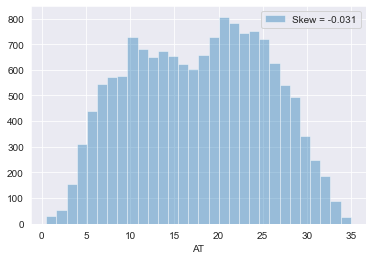

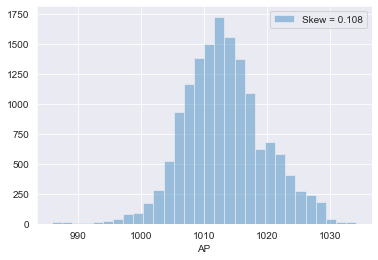

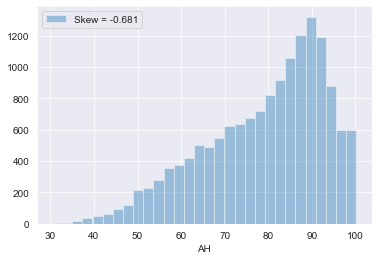

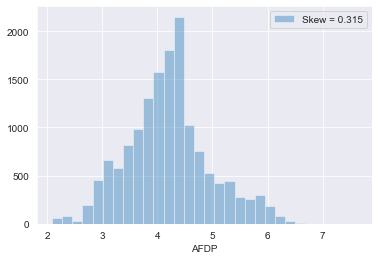

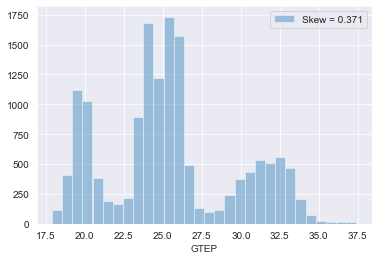

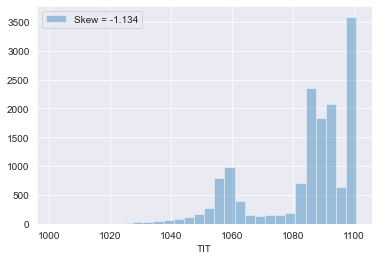

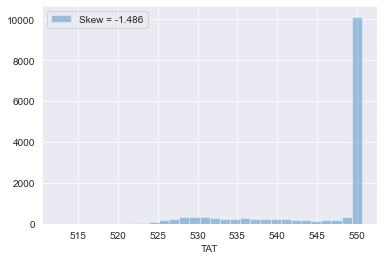

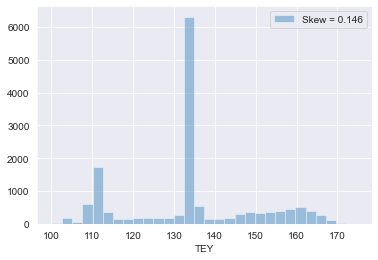

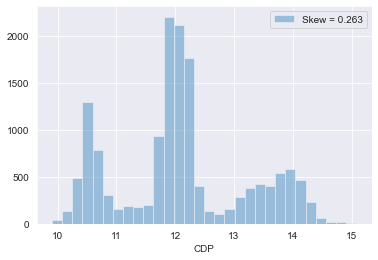

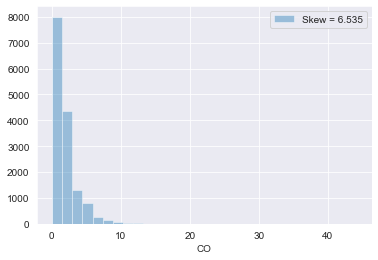

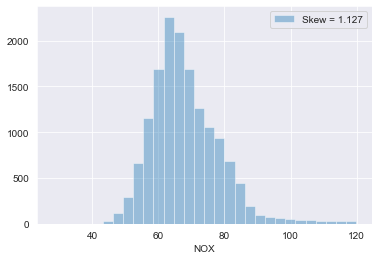

In [15]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

Some of the features are normally distributed. The features AH, CO, TITy and TATa exhibit the highest skew coefficients. Moreover, the distribution of Carbon Mono oxide (CO) and Turbine inlet temperature	(TIT) and Turbine after temperature	(TAT) seem to contain many outliers. Let's identify the indices of the observations containing outliers using Turkey's method.

In [16]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features])))) 

The dataset contains 1543 observations with more than 2 outliers


##### Mmm hmm! there exists observations with multiple outliers. 

Let's examine the boxplots for the several distributions

In [17]:
numerical_features

['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO', 'NOX']

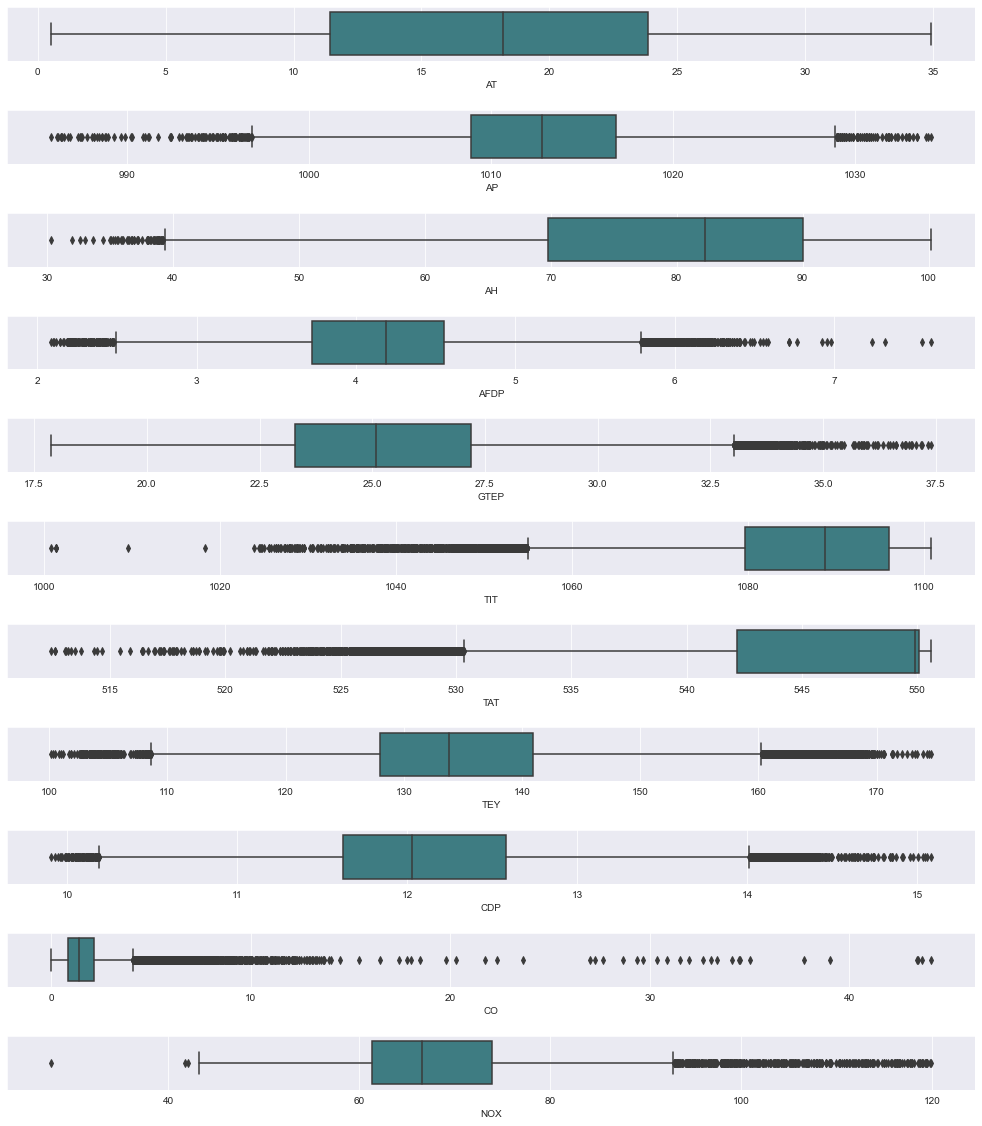

In [18]:
ot=df.copy() 
fig, axes=plt.subplots(11,1,figsize=(14,16),sharex=False,sharey=False)
sns.boxplot(x='AT',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='AP',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='AH',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='AFDP',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='GTEP',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='TIT',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='TAT',data=ot,palette='crest',ax=axes[6])
sns.boxplot(x='TEY',data=ot,palette='crest',ax=axes[7])
sns.boxplot(x='CDP',data=ot,palette='crest',ax=axes[8])
sns.boxplot(x='CO',data=ot,palette='crest',ax=axes[9])
sns.boxplot(x='NOX',data=ot,palette='crest',ax=axes[10])
plt.tight_layout(pad=2.0)

<AxesSubplot:>

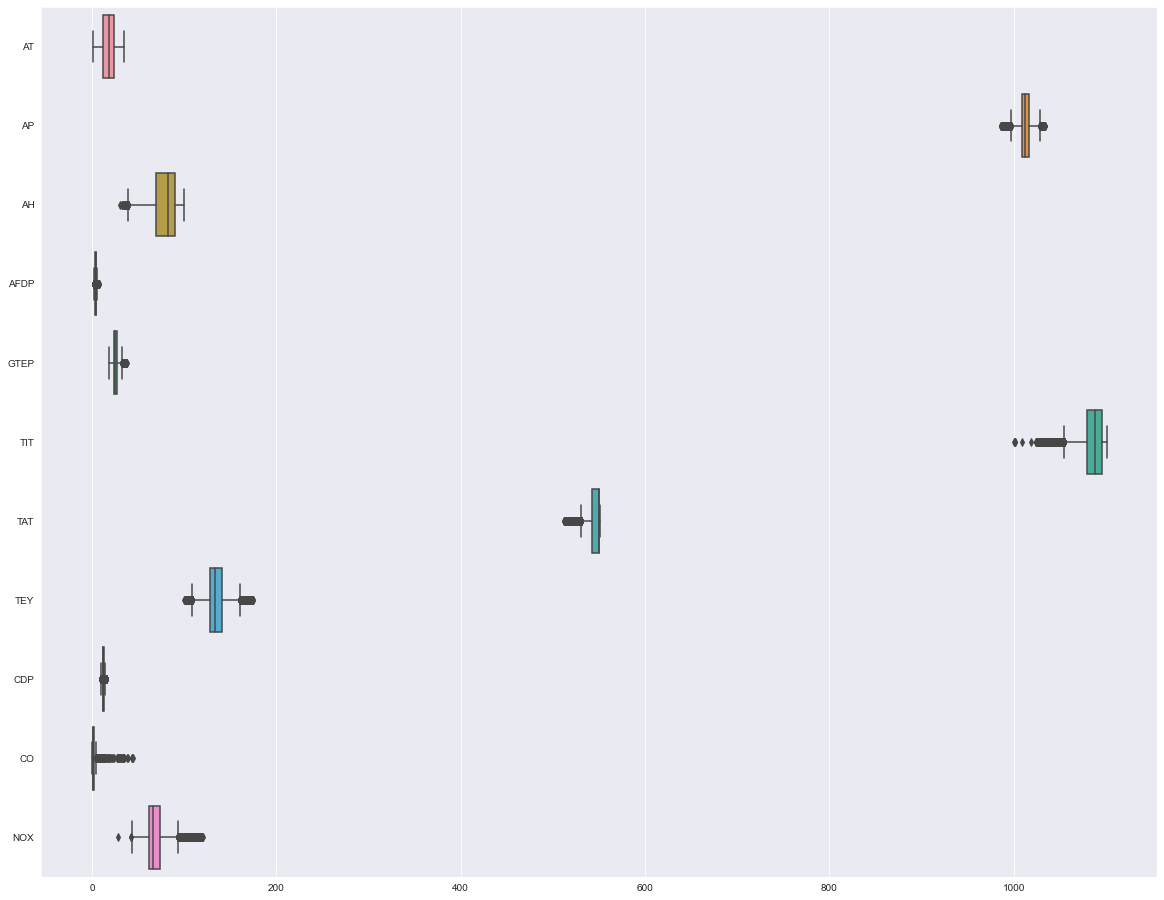

In [19]:
#outlier
plt.figure(figsize=(20,16))
sns.boxplot(data=df[numerical_features], orient="h")

Text(0.5, 1.0, 'Histogram of the Target Column')

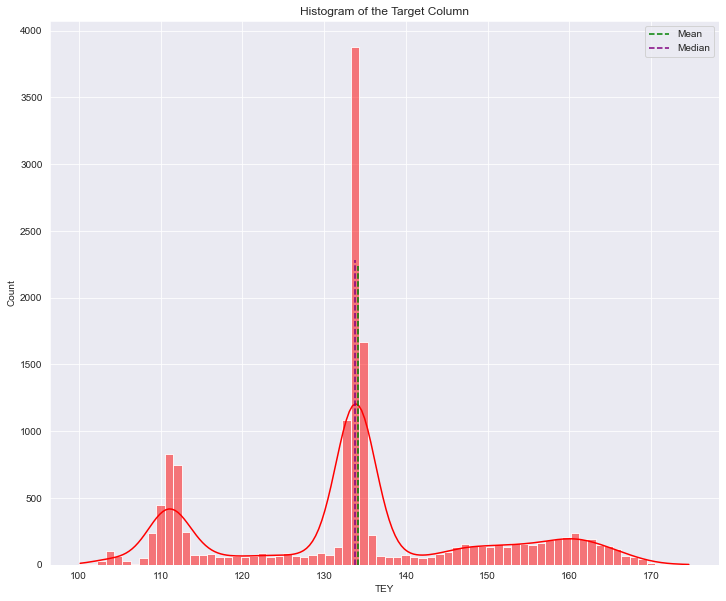

In [20]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,10))
sns.histplot(data=df,x="TEY",color="red",kde=True)
plt.axvline(x=df["TEY"].mean(),ymax=0.55,color="green",linestyle='--',label="Mean")
plt.axvline(x=df["TEY"].median(),ymax=0.56,color="purple",linestyle='--',label="Median")
plt.legend()
plt.title("Histogram of the Target Column")

Text(0.5, 1.0, 'Cumulative of the Target Column')

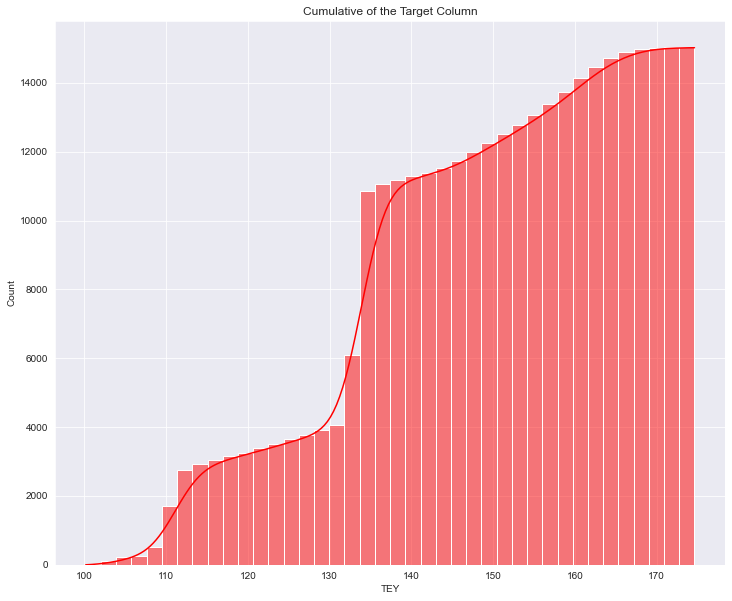

In [21]:
plt.figure(figsize = (12,10))
sns.histplot(df["TEY"],kde=True,bins=40,color="red",cumulative=True)
plt.title("Cumulative of the Target Column")

#### Unsurprisingly, Mostly none of the features are on the same scale as we already saw in the previous section.

+ ### Multivariate Analysis<a class="anchor" id="4.2"></a>


Let's now proceed by drawing a pairplot to visually examine the correlation between the features.

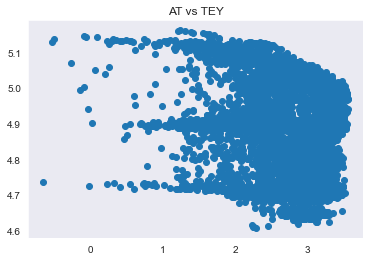

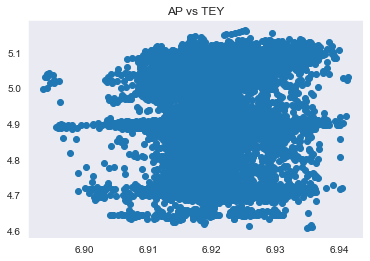

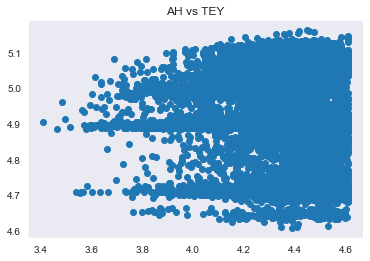

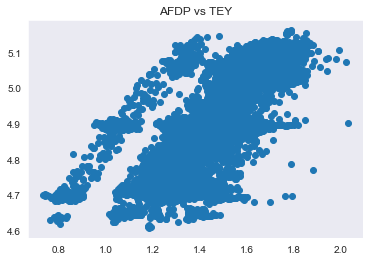

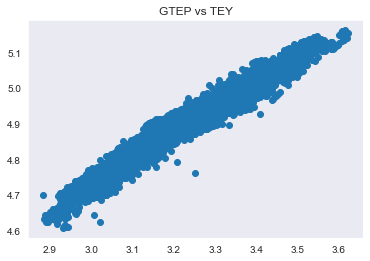

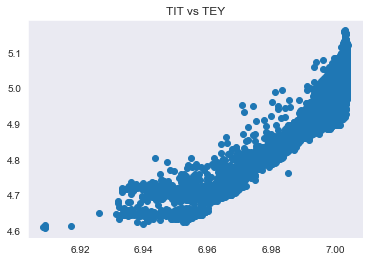

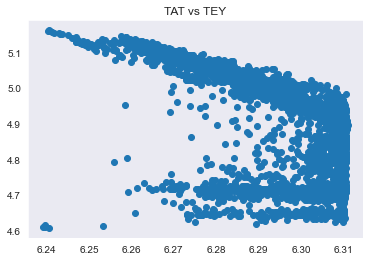

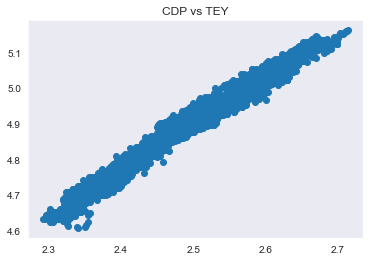

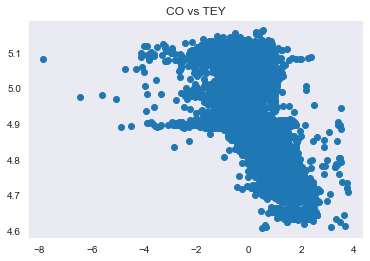

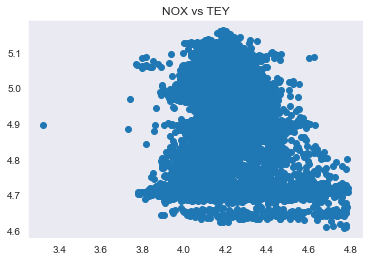

In [22]:
for i in df.columns:
    if i!="TEY": 
        plt.scatter(np.log(df[i]), np.log(df['TEY']))
        plt.title(i+ ' vs TEY')
        plt.grid()
        plt.show()

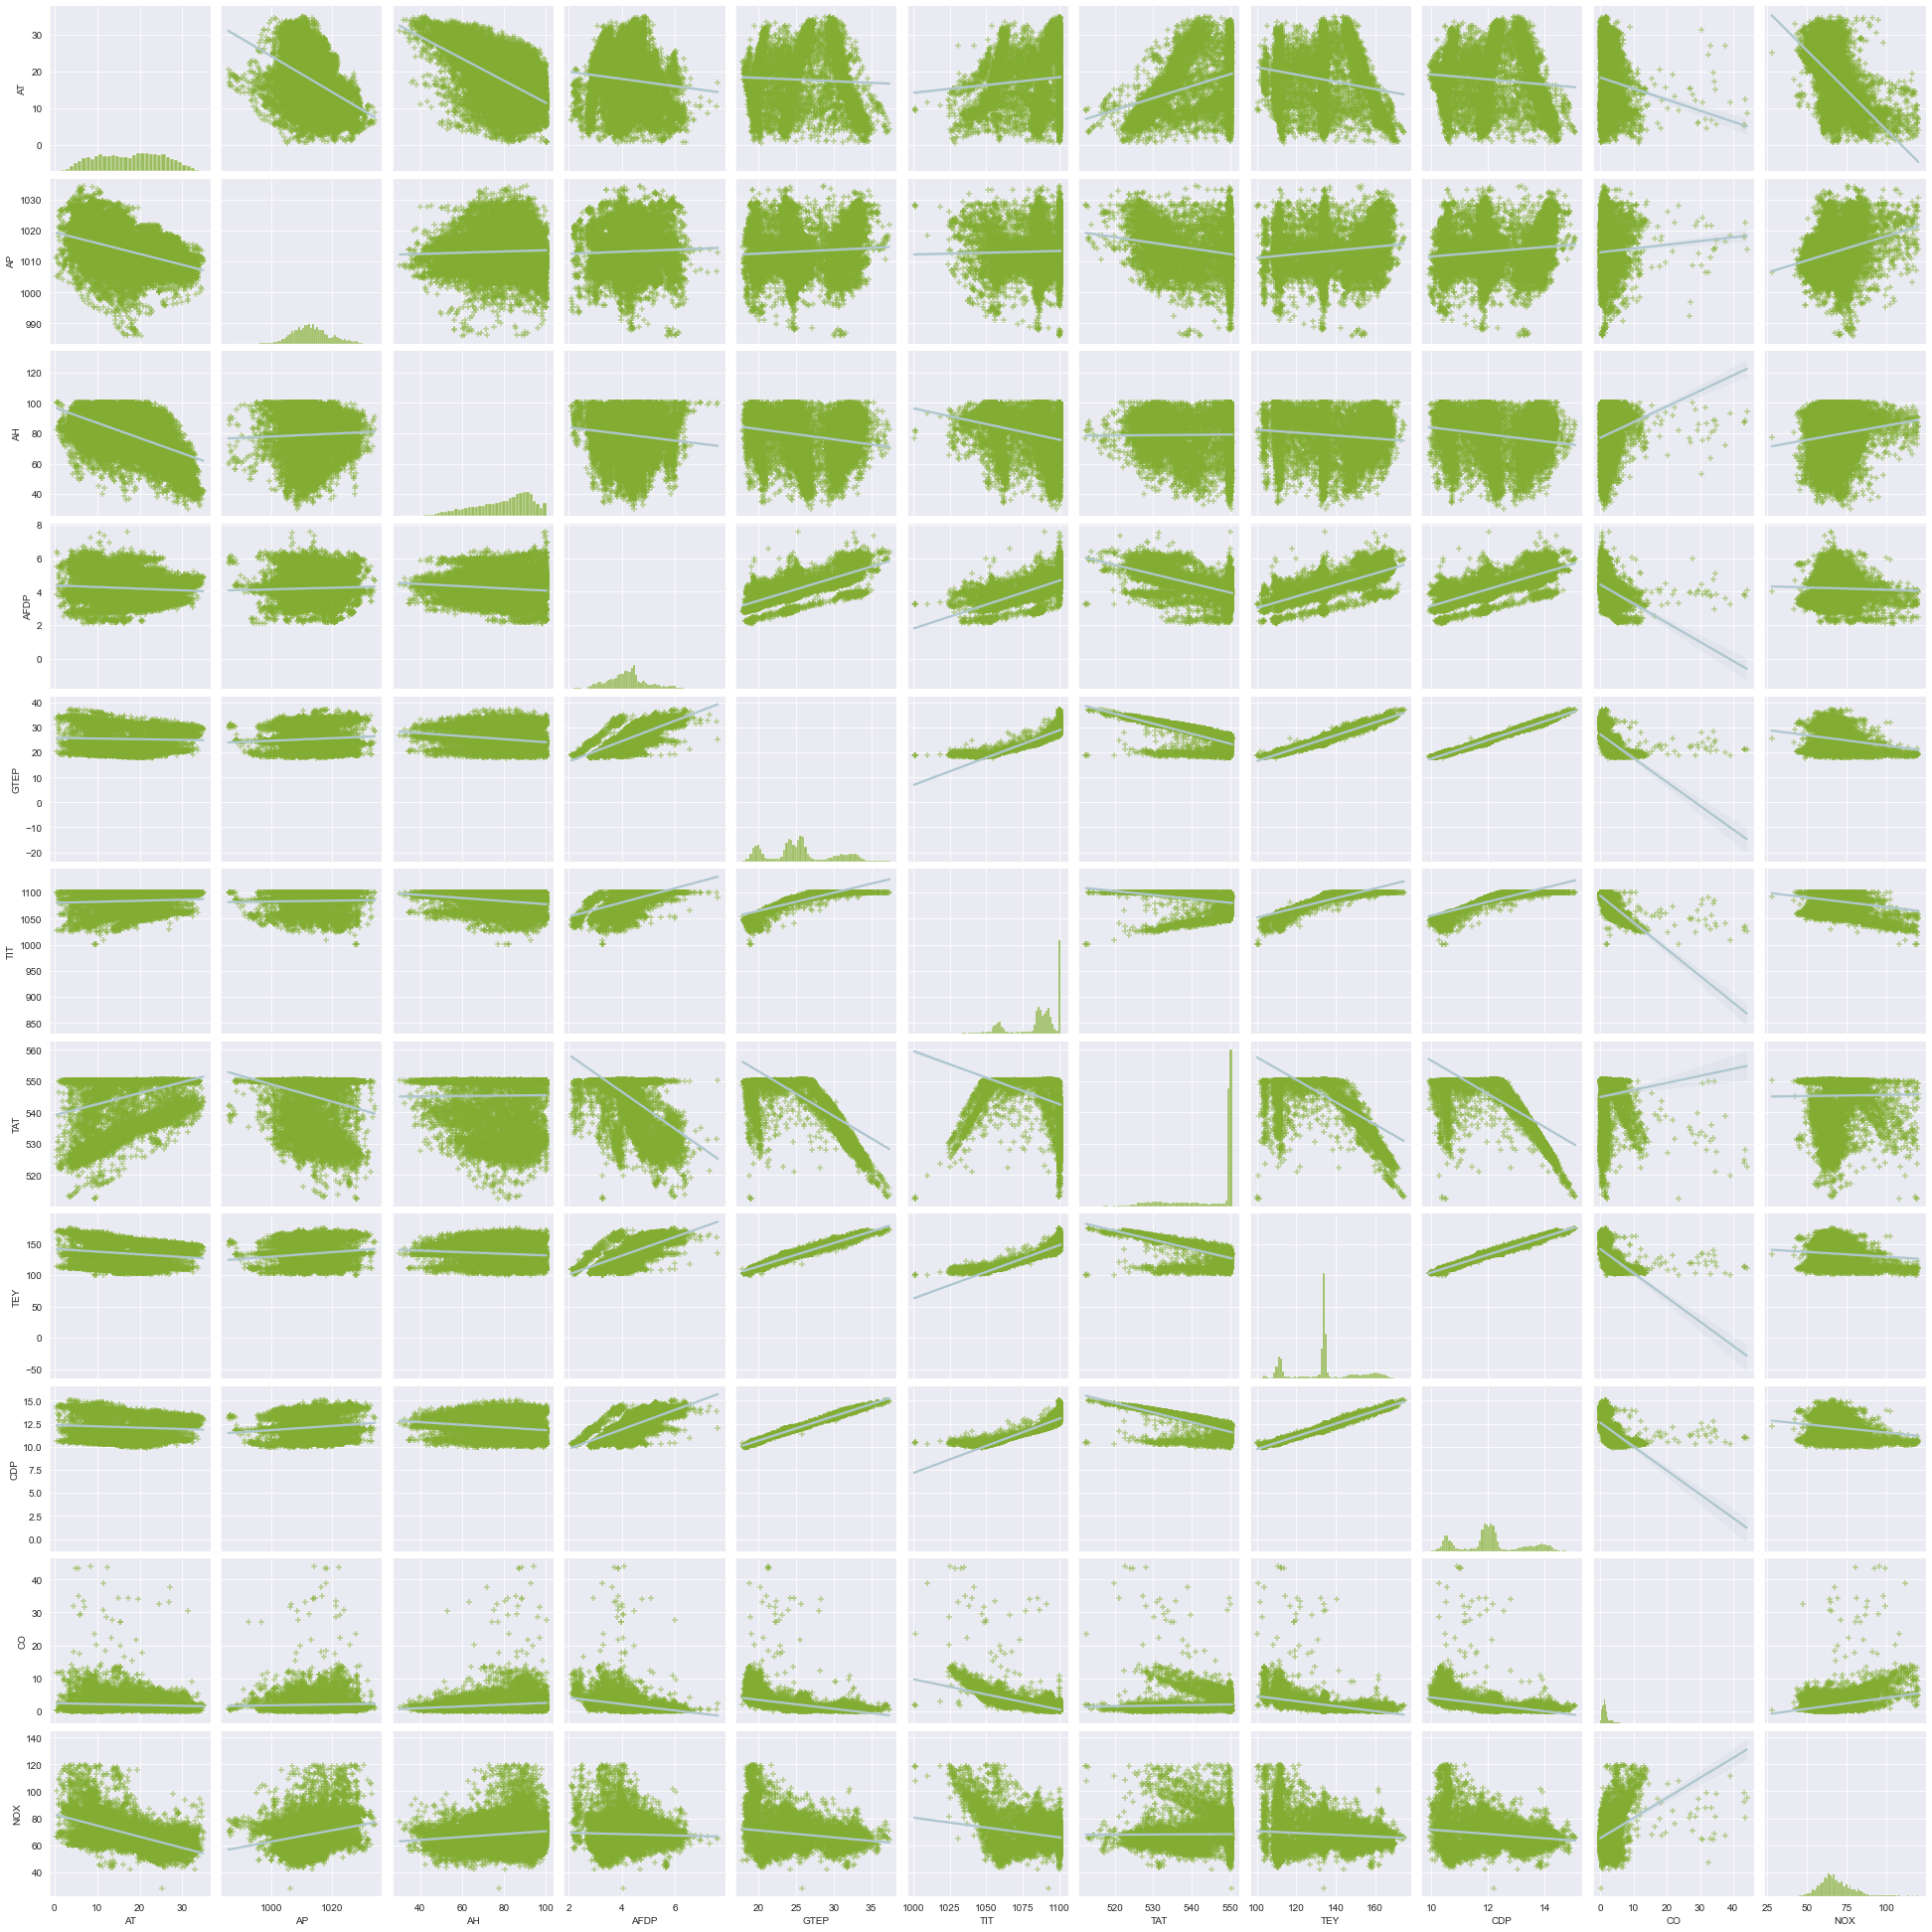

In [23]:
sns.pairplot(df,
                 markers="+",
                 kind='reg',
                 diag_kind="auto",
                 plot_kws={'line_kws':{'color':'#aec6cf'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#82ad32'}},
               
                 diag_kws= {'color': '#82ad32'})

<Figure size 1440x1440 with 0 Axes>

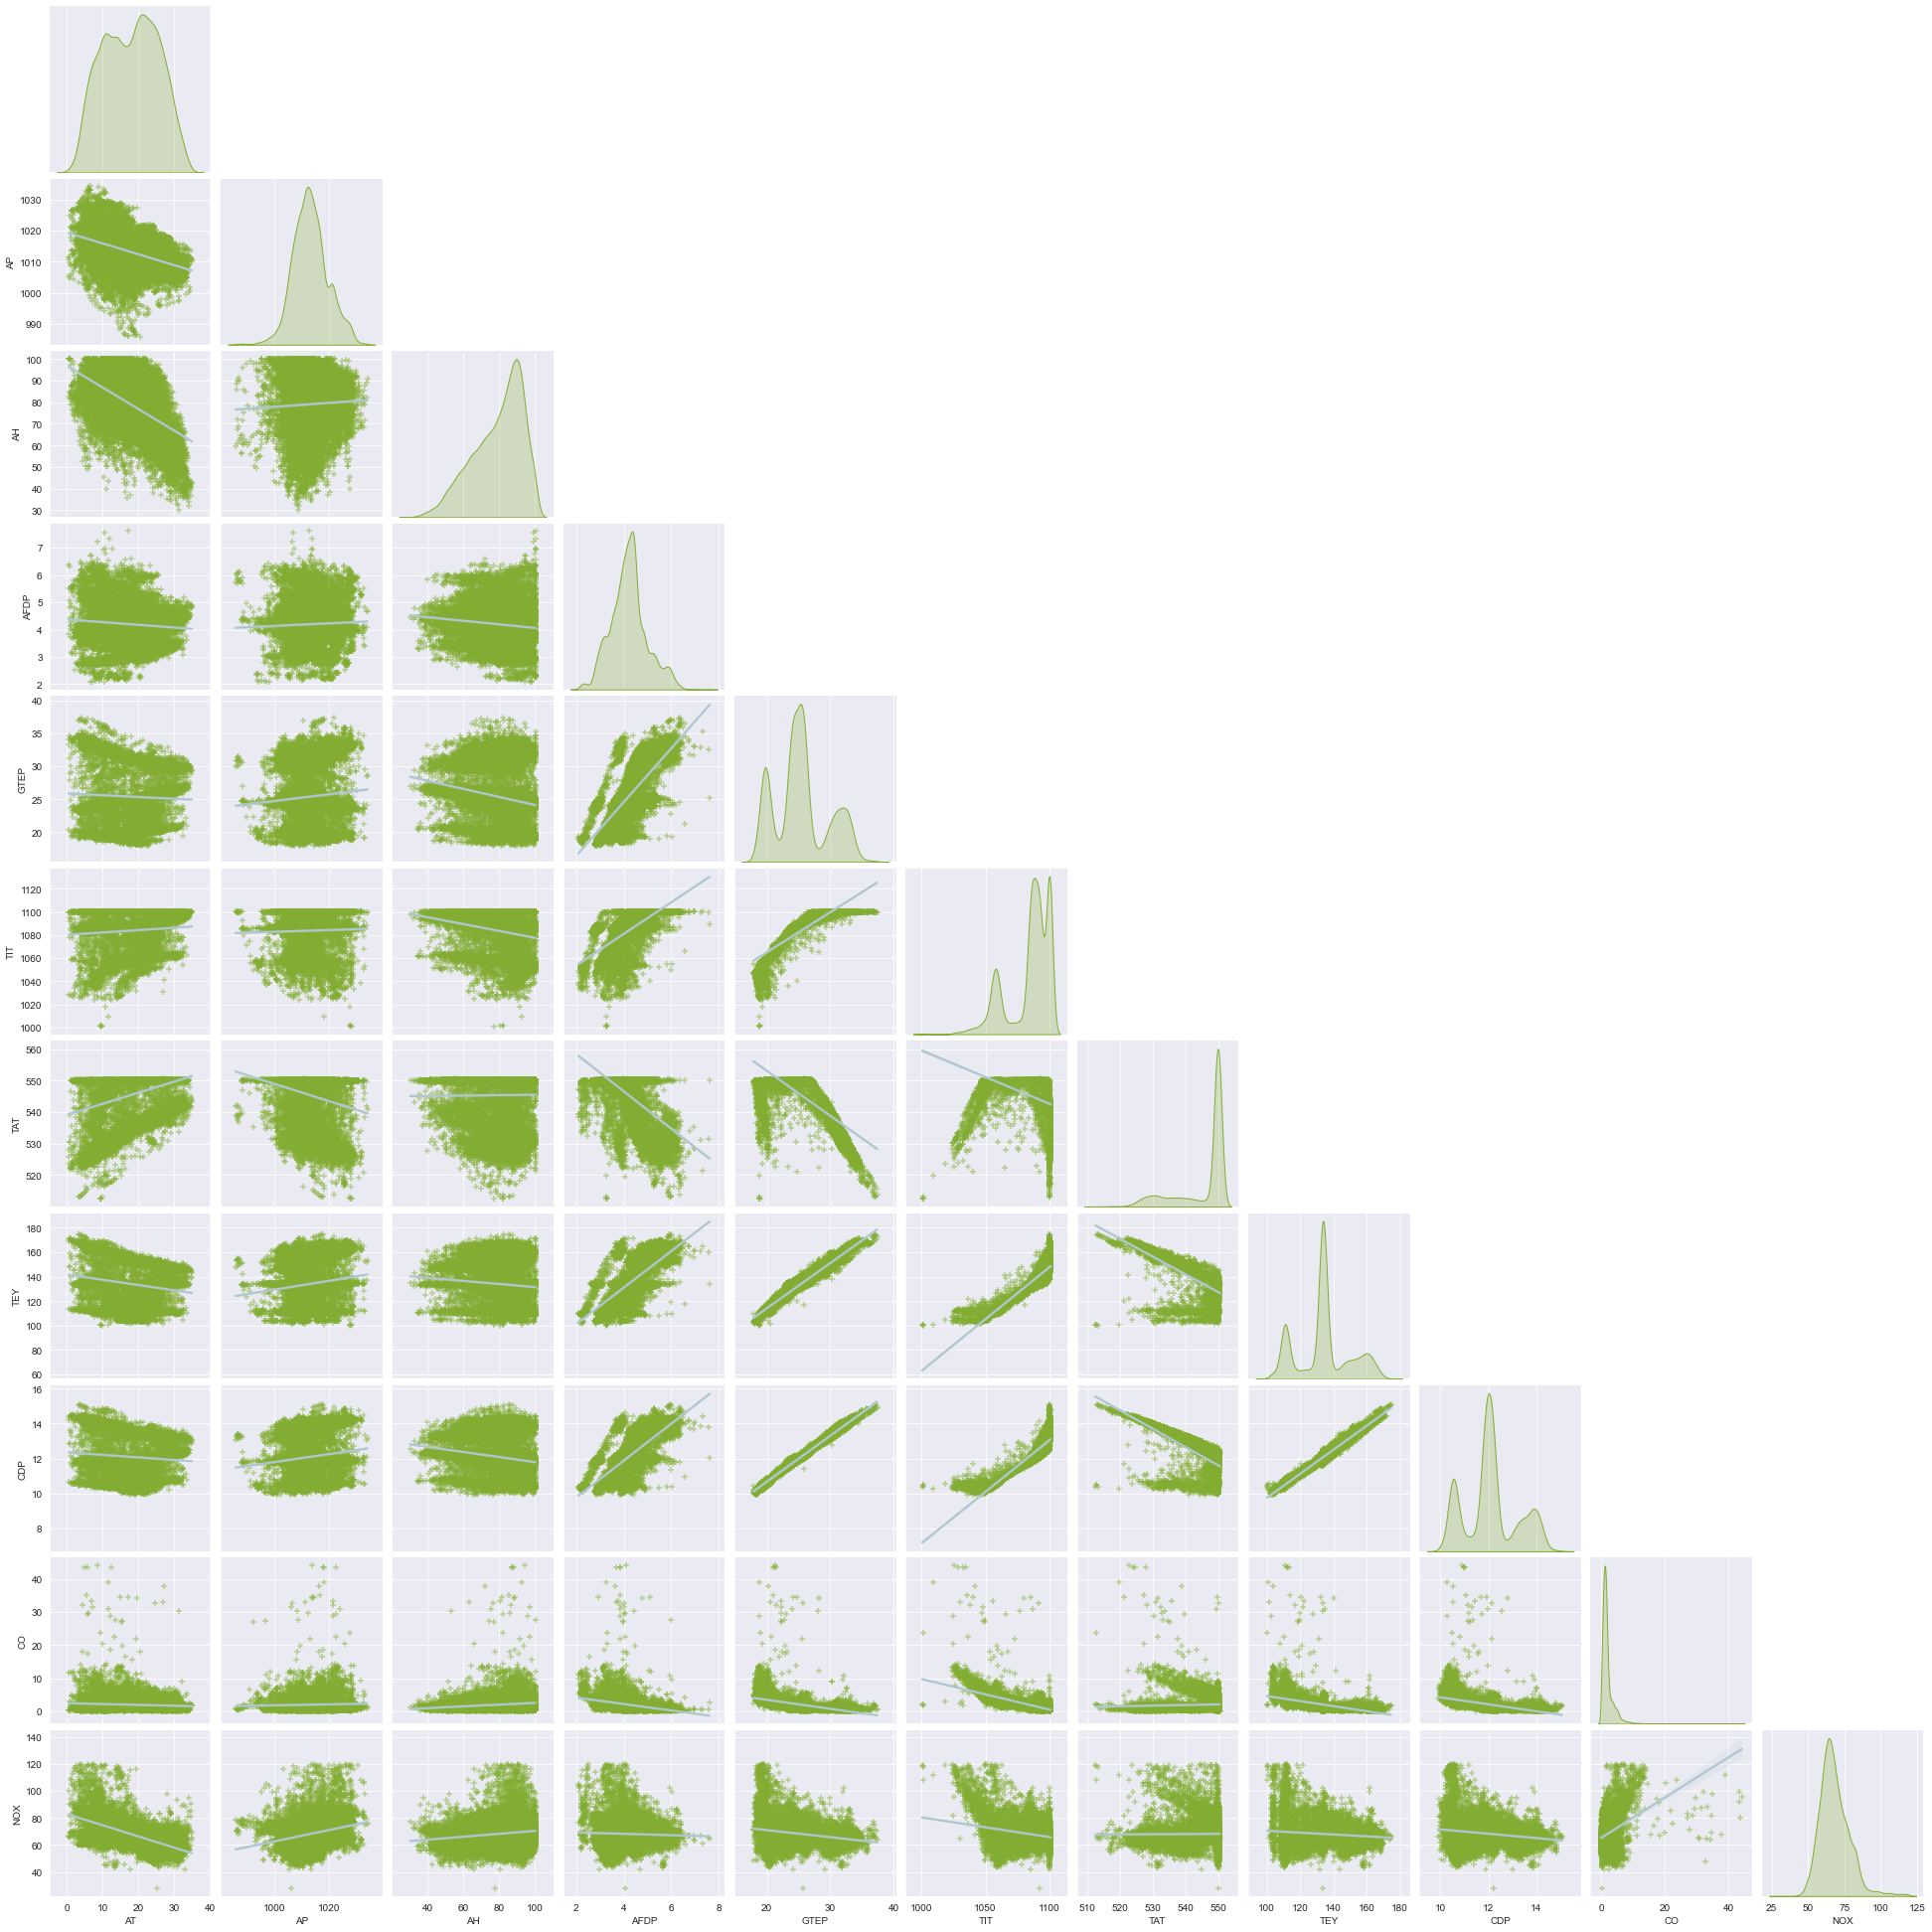

In [24]:
plt.figure(figsize=(20,20))
sns.pairplot(df,
                 markers="+",
                 kind='reg',
                 diag_kind="kde",
                 plot_kws={'line_kws':{'color':'#aec6cf'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#82ad32'}},
               corner=True,
                 diag_kws= {'color': '#82ad32'})

***Pearson's Correlation Coefficient***: helps you find out the relationship between two quantities. It gives you the measure of the strength of association between two variables. The value of Pearson's Correlation Coefficient can be between -1 to +1. 1 means that they are highly correlated and 0 means no correlation.

A heat map is a two-dimensional representation of information with the help of colors. Heat maps can help the user visualize simple or complex information.

<AxesSubplot:>

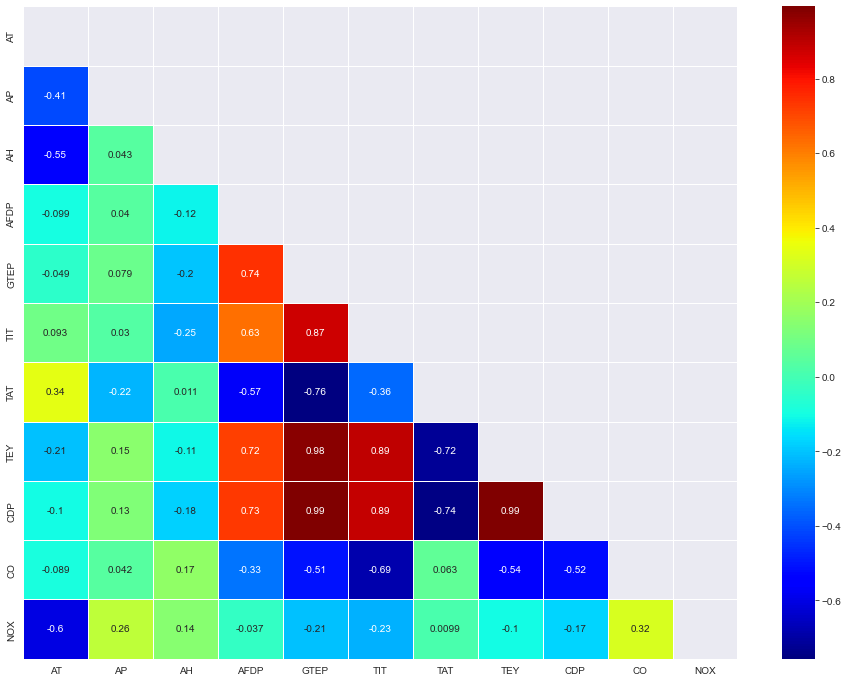

In [25]:
# Having a look at the correlation matrix

plt.figure(figsize=(16,12))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=df.corr(), cmap="jet", annot=True,linewidths=1, linecolor='white',mask=mask)

In [26]:
x = df.drop('TEY', axis=1)
y = df[["TEY"]]

Text(0.5, 1.0, 'Correlation with Turbine energy yield \n')

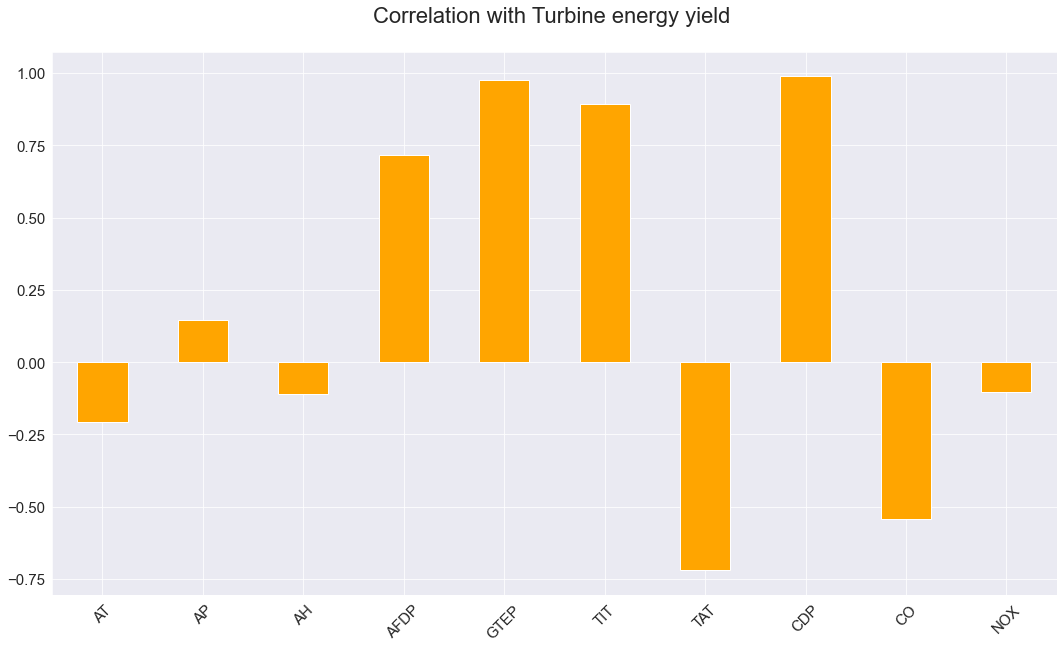

In [27]:
data2 = df.copy()

correlations = data2.corrwith(df.TEY)
correlations = correlations[correlations!=1]
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations =correlations[correlations<0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'orange',
        rot = 45, grid = True)
plt.title('Correlation with Turbine energy yield \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

##  Feature Selection Technique<a class="anchor" id="5"></a>

In [28]:
#Feature importance
from numpy import set_printoptions

In [29]:
# feature extraction
test = SelectKBest(score_func=mutual_info_regression, k='all')
fit = test.fit(x, y)

In [30]:
# summarize scores
scores = fit.scores_

features = fit.transform(x)

In [31]:
score_df = pd.DataFrame(list(zip(scores, x.columns)),
               columns =['Score', 'Feature'])
score_df.sort_values(by="Score", ascending=False, inplace=True)
score_df

Score Feature
7  1.712603     CDP
4  1.600628    GTEP
5  1.323138     TIT
6  0.893555     TAT
3  0.660259    AFDP
8  0.512194      CO
0  0.412181      AT
9  0.300458     NOX
1  0.138300      AP
2  0.097668      AH

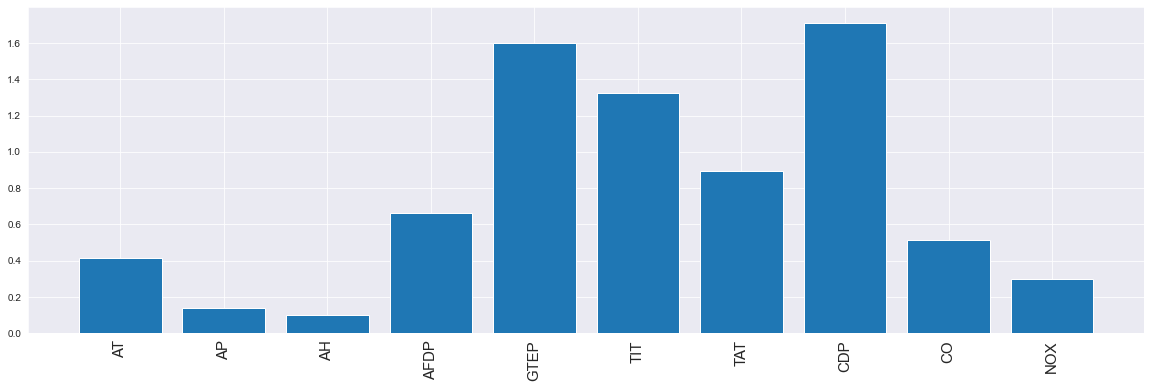

In [32]:
fig, axes = plt.subplots(figsize=(20, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

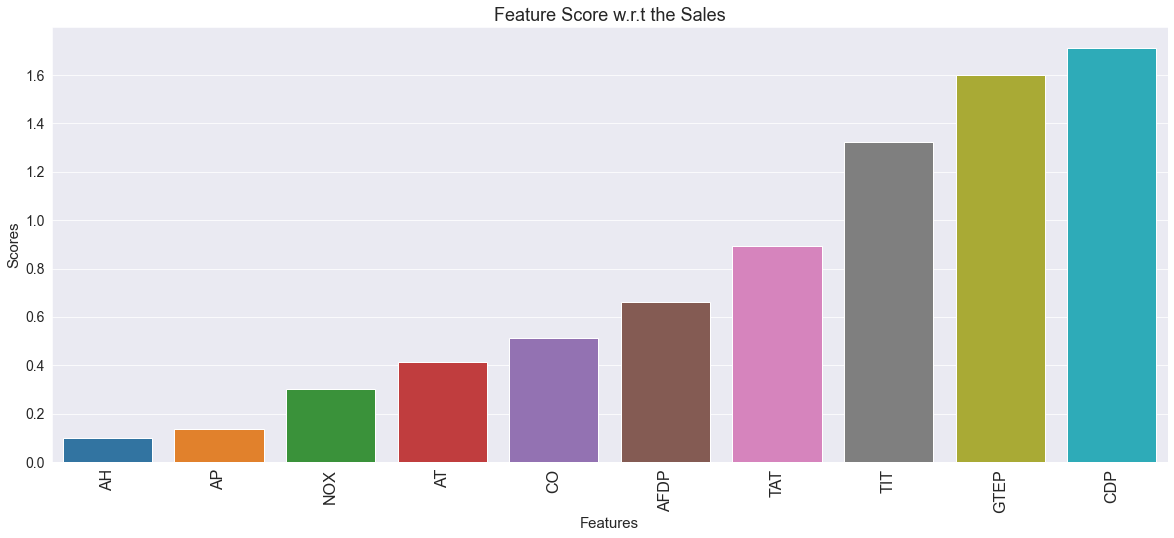

In [33]:
plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Score", 
            data=score_df, 
            order=score_df.sort_values('Score').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

In [34]:
score_df.sort_values('Score',ascending=False)

Score Feature
7  1.712603     CDP
4  1.600628    GTEP
5  1.323138     TIT
6  0.893555     TAT
3  0.660259    AFDP
8  0.512194      CO
0  0.412181      AT
9  0.300458     NOX
1  0.138300      AP
2  0.097668      AH

In [35]:
model_data = df[['CDP', 'GTEP','TIT', 'TAT', 'AFDP', 'CO', 'AT',"TEY"]]
model_data.head()

CDP    GTEP     TIT     TAT    AFDP      CO      AT     TEY
0  10.605  19.663  1059.2  550.00  3.5000  3.1547  6.8594  114.70
1  10.598  19.728  1059.3  550.00  3.4998  3.2363  6.7850  114.72
2  10.601  19.779  1059.4  549.87  3.4824  3.2012  6.8977  114.71
3  10.606  19.792  1059.6  549.99  3.4805  3.1923  7.0569  114.72
4  10.612  19.765  1059.7  549.98  3.4976  3.2484  7.3978  114.72

### Data Pre-Processing<a class="anchor" id="5.1"></a>


#### Feature Engineering

#### Applying some Data Transformation to increase the linear realtionship and improve our model prediction as well it scores

#### Applying Standard Scaler
+ For each feature, the Standard Scaler scales the values such that the mean is 0 and the standard deviation is 1(or the variance).
+ x_scaled = x – mean/std_dev
+ However, Standard Scaler assumes that the distribution of the variable is normal. Thus, in case, the variables are not normally distributed, we either choose a different scaler or first, convert the variables to a normal distribution and then apply this scaler

In [36]:
continuous_feature=[feature for feature in model_data.columns if model_data[feature].dtype!='O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 8


In [37]:
df_standard_scaled = model_data.copy()
features = df_standard_scaled[continuous_feature]

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_standard_scaled[continuous_feature] = scaler.fit_transform(features.values)
df_standard_scaled.head()

CDP      GTEP       TIT       TAT      AFDP        CO        AT  \
0 -1.357331 -1.379101 -1.488376  0.585240 -0.921232  0.532012 -1.439778   
1 -1.363676 -1.363528 -1.482325  0.585240 -0.921495  0.568733 -1.449601   
2 -1.360957 -1.351309 -1.476275  0.568715 -0.944385  0.552938 -1.434721   
3 -1.356424 -1.348194 -1.464173  0.583969 -0.946884  0.548933 -1.413702   
4 -1.350985 -1.354663 -1.458123  0.582698 -0.924389  0.574179 -1.368693   

        TEY  
0 -1.231172  
1 -1.229909  
2 -1.230541  
3 -1.229909  
4 -1.229909

#### Now if we check the mean and standard deviation of our scaled data it should have a Mean '0' and Standard deviation '1'

In [39]:
print('Mean' '\n',np.round(df_standard_scaled.mean(),1),'\n' 'Standard Devaition','\n',np.round(df_standard_scaled.std()),1)

Mean
 CDP     0.0
GTEP    0.0
TIT    -0.0
TAT     0.0
AFDP    0.0
CO      0.0
AT     -0.0
TEY     0.0
dtype: float64 
Standard Devaition 
 CDP     1.0
GTEP    1.0
TIT     1.0
TAT     1.0
AFDP    1.0
CO      1.0
AT      1.0
TEY     1.0
dtype: float64 1


### Test Train Split With Imbalanced Dataset<a class="anchor" id="5.2"></a>


In [40]:
x = df_standard_scaled.drop('TEY',axis=1)
y = df_standard_scaled[['TEY']]

In [41]:
# Splitting data into test data and train data

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)

##  Hyperparameter Tuning<a class="anchor" id="6"></a>

### **`Hyperparameter Tuning`**: Optimal Learning rate ,Number of Layers and Neurons<a class="anchor" id="6.1"></a>

In [42]:
def build_model(hp):
    model =Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=100,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [43]:
tuner = RandomSearch(build_model,objective='val_mean_absolute_error',max_trials=5,  executions_per_trial=3,directory='project',project_name='Gas Turbine')

Reloading Oracle from existing project project\Gas Turbine\oracle.json
Reloading Tuner from project\Gas Turbine\tuner0.json


In [44]:
tuner.search_space_summary()

Search space summary
Default search space size: 16
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': None}
units_6 (Int)
{'default': None, 'co

In [45]:
tuner.search(x_train, y_train,epochs=100,validation_data=(x_test, y_test))

Oracle triggered exit


In [46]:
tuner.results_summary()

Results summary
Results in project\Gas Turbine
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 9
units_0: 64
units_1: 64
learning_rate: 0.0001
units_2: 64
units_3: 96
units_4: 96
units_5: 96
units_6: 64
units_7: 32
units_8: 96
units_9: 64
units_10: 32
units_11: 96
units_12: 32
units_13: 32
Score: 0.02410721592605114
Trial summary
Hyperparameters:
num_layers: 14
units_0: 64
units_1: 96
learning_rate: 0.0001
units_2: 32
units_3: 96
units_4: 32
units_5: 64
units_6: 64
units_7: 32
units_8: 32
units_9: 64
units_10: 96
units_11: 96
units_12: 32
units_13: 32
Score: 0.02424335479736328
Trial summary
Hyperparameters:
num_layers: 3
units_0: 64
units_1: 96
learning_rate: 0.0001
units_2: 32
units_3: 32
units_4: 64
units_5: 64
units_6: 64
units_7: 32
units_8: 96
units_9: 96
units_10: 64
units_11: 64
units_12: 64
units_13: 64
Score: 0.024403678253293037
Trial summary
Hyperparameters:
num_layers: 10
units_0: 32
units_1: 64
learning_rate: 0.001
units_2: 64
units_3: 64
units_4: 96
uni

###  **`Hyperparameter Tuning`**: Optimal Batch_size, Number of Epochs<a class="anchor" id="6.2"></a>

In [47]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(32,input_dim=7,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(units=1,activation="linear"))
    
    adam=Adam(learning_rate=0.001)
    model1.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model1

In [48]:
model1 =KerasRegressor(build_fn=create_model,verbose=0)
batch_size=[10,20,40,50]
epochs=[10,50,100,200]
param_grid=dict(batch_size=batch_size,epochs=epochs)
grid = GridSearchCV(estimator=model1,param_grid=param_grid,cv=KFold(),verbose=10)

In [49]:
grid_result = grid.fit(x_test,y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START batch_size=10, epochs=10...................................
[CV 1/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.050 total time=  21.3s
[CV 2/5; 1/16] START batch_size=10, epochs=10...................................
[CV 2/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.059 total time=  13.5s
[CV 3/5; 1/16] START batch_size=10, epochs=10...................................
[CV 3/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.082 total time=  15.3s
[CV 4/5; 1/16] START batch_size=10, epochs=10...................................
[CV 4/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.042 total time=  13.6s
[CV 5/5; 1/16] START batch_size=10, epochs=10...................................
[CV 5/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.031 total time=  13.3s
[CV 1/5; 2/16] START batch_size=10, epochs=50...................................
[CV 1/5; 2/16] END ...batch_size=10, epochs=50;,

[CV 1/5; 11/16] END .batch_size=40, epochs=100;, score=-0.043 total time=  32.5s
[CV 2/5; 11/16] START batch_size=40, epochs=100.................................
[CV 2/5; 11/16] END .batch_size=40, epochs=100;, score=-0.028 total time=  33.0s
[CV 3/5; 11/16] START batch_size=40, epochs=100.................................
[CV 3/5; 11/16] END .batch_size=40, epochs=100;, score=-0.032 total time=  33.7s
[CV 4/5; 11/16] START batch_size=40, epochs=100.................................
[CV 4/5; 11/16] END .batch_size=40, epochs=100;, score=-0.029 total time=  30.6s
[CV 5/5; 11/16] START batch_size=40, epochs=100.................................
[CV 5/5; 11/16] END .batch_size=40, epochs=100;, score=-0.027 total time=  23.5s
[CV 1/5; 12/16] START batch_size=40, epochs=200.................................
[CV 1/5; 12/16] END .batch_size=40, epochs=200;, score=-0.043 total time= 2.5min
[CV 2/5; 12/16] START batch_size=40, epochs=200.................................
[CV 2/5; 12/16] END .batch_s

In [50]:
print('Best {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best -0.0310655128210783, using {'batch_size': 40, 'epochs': 50}
-0.05288269408047199,0.01714742893836013 with {'batch_size': 10, 'epochs': 10}
-0.045896312594413756,0.011571688003479373 with {'batch_size': 10, 'epochs': 50}
-0.03289381079375744,0.004905871695211956 with {'batch_size': 10, 'epochs': 100}
-0.03229139633476734,0.002547542242297257 with {'batch_size': 10, 'epochs': 200}
-0.04315899536013603,0.008677256824123026 with {'batch_size': 20, 'epochs': 10}
-0.034927047044038775,0.0021932308756112385 with {'batch_size': 20, 'epochs': 50}
-0.03308130241930485,0.003813962600065322 with {'batch_size': 20, 'epochs': 100}
-0.03306378535926342,0.004047879305642256 with {'batch_size': 20, 'epochs': 200}
-0.038770643249154094,0.009912516287039583 with {'batch_size': 40, 'epochs': 10}
-0.0310655128210783,0.002208468080854493 with {'batch_size': 40, 'epochs': 50}
-0.03181933388113976,0.005636061613337659 with {'batch_size': 40, 'epochs': 100}
-0.03218136802315712,0.006137095450716178 with {

###  **`Hyperparameter Tuning`**: Optimal Droupout rate<a class="anchor" id="6.3"></a>

In [51]:
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(32,input_dim=7,activation='relu'))
    model2.add(Dense(64,activation='relu'))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(96,activation="relu"))
    model2.add(Dense(32,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(64,activation="relu"))
    model2.add(Dense(units=1,activation="linear"))
    
    adam=Adam(lr=0.001)
    model2.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model2

In [52]:
model2=KerasRegressor(build_fn=create_model,batch_size=40,epochs=200,verbose=0)
dropout_rate=[0.0,0.1,0.2,0.3,0.4,0.5]
param_grid=dict(dropout_rate=dropout_rate)
grid2 = GridSearchCV(estimator=model2,param_grid=param_grid,cv=KFold(),verbose=10)

In [53]:
grid_result2 = grid2.fit(x_test,y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................
[CV 1/5; 1/6] END ............dropout_rate=0.0;, score=-0.031 total time= 1.3min
[CV 2/5; 1/6] START dropout_rate=0.0............................................
[CV 2/5; 1/6] END ............dropout_rate=0.0;, score=-0.031 total time= 1.3min
[CV 3/5; 1/6] START dropout_rate=0.0............................................
[CV 3/5; 1/6] END ............dropout_rate=0.0;, score=-0.039 total time= 1.3min
[CV 4/5; 1/6] START dropout_rate=0.0............................................
[CV 4/5; 1/6] END ............dropout_rate=0.0;, score=-0.035 total time= 1.2min
[CV 5/5; 1/6] START dropout_rate=0.0............................................
[CV 5/5; 1/6] END ............dropout_rate=0.0;, score=-0.030 total time= 1.3min
[CV 1/5; 2/6] START dropout_rate=0.1............................................
[CV 1/5; 2/6] END ............dropout_rate=0.1;, 

In [54]:
print('Best {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best -0.029553091526031493, using {'dropout_rate': 0.1}
-0.033143512159585956,0.0034247830893401787 with {'dropout_rate': 0.0}
-0.029553091526031493,0.0029550647793346566 with {'dropout_rate': 0.1}
-0.03023534156382084,0.0039050996673702376 with {'dropout_rate': 0.2}
-0.029572206363081933,0.0035553627094440797 with {'dropout_rate': 0.3}
-0.033171717822551725,0.0056749190883754125 with {'dropout_rate': 0.4}
-0.03332209065556526,0.005601435779943202 with {'dropout_rate': 0.5}


###  **`Hyperparameter Tuning`**: Optimal Activation Function and Kernel Initializer<a class="anchor" id="6.4"></a>

In [55]:
def create_model(activation_function,init):
    model3 = Sequential()
    model3.add(Dense(32,input_dim=7,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(units=1,activation="linear"))
    
    adam=Adam(lr=0.001)
    model3.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model3

In [56]:
model3=KerasRegressor(build_fn=create_model,batch_size=40,epochs=200,verbose=0)
activation_function=['softmax','tanh','relu']
init=['normal','uniform','zero']
param_grid=dict(activation_function=activation_function,init=init)
grid3 = GridSearchCV(estimator=model3,param_grid=param_grid,cv=KFold(),verbose=10)

In [ ]:
grid_result3 = grid3.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START activation_function=softmax, init=normal....................
[CV 1/5; 1/9] END activation_function=softmax, init=normal;, score=-0.827 total time= 2.2min
[CV 2/5; 1/9] START activation_function=softmax, init=normal....................
[CV 2/5; 1/9] END activation_function=softmax, init=normal;, score=-0.913 total time= 2.4min
[CV 3/5; 1/9] START activation_function=softmax, init=normal....................
[CV 3/5; 1/9] END activation_function=softmax, init=normal;, score=-0.882 total time= 2.4min
[CV 4/5; 1/9] START activation_function=softmax, init=normal....................
[CV 4/5; 1/9] END activation_function=softmax, init=normal;, score=-0.765 total time= 2.3min
[CV 5/5; 1/9] START activation_function=softmax, init=normal....................
[CV 5/5; 1/9] END activation_function=softmax, init=normal;, score=-0.675 total time= 2.4min
[CV 1/5; 2/9] START activation_function=softmax, init=uniform.........

In [ ]:
print('Best {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means = grid_result3.cv_results_["mean_test_score"]
stds = grid_result3.cv_results_["std_test_score"]
params = grid_result3.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

###  Model Building Neural Networks<a class="anchor" id="7"></a>

#### Standardizing only predictor variable - after train test split

In [ ]:
model_data

In [ ]:
#assigning predictor variables to x and response variable to y
x = model_data.drop('TEY', axis=1)
y = model_data[["TEY"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

scaler_train = StandardScaler()
scaler_test = StandardScaler()

x_train_scaled = scaler_train.fit_transform(x_train) # scaling train data -- predictor
x_test_scaled  = scaler_test.fit_transform(x_test) # scaling test data -- predictor

print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

#for removing heading from y_test
#y_test = y_test.values

In [ ]:
# since we have continuous ouput, AF is not required in the o/p layer
model = Sequential()
model.add( Dense( units = 50 , activation = 'relu' , kernel_initializer = 'normal', input_dim = 7)) # input layer
model.add( Dense( units = 20 , activation = 'tanh' , kernel_initializer = 'normal' )) # hidden layer
model.add( Dense( units = 1  , kernel_initializer = 'normal' )) # o/p layer

model.compile(optimizer= "adam", loss="mse", metrics= ["mae", "mse"])
model.fit(x_train_scaled, y_train , batch_size=50, validation_split=0.3, epochs=100,  verbose=1)

In [ ]:
def toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test):
        
    #defining list of hyperparameters
    batch_size_list = [5 , 10 , 15 , 20]
    epoch_list      = [5 , 10 , 50 , 100]
     
    bestParamTable = pd.DataFrame()
    
    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:
            
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=x_train_scaled.shape[1], kernel_initializer='normal', activation='relu'))
            
            # Defining the Second layer of the model
            model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(optimizer ='adam', loss = 'mean_squared_error')
            
            # Fitting the ANN to the Training set
            model.fit(x_train_scaled, y_train , batch_size=batch_trial, epochs=epochs_trial,  verbose=0)
                        
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(x_test_scaled))/y_test))  
                        
            bestParamTable=bestParamTable.append(pd.DataFrame(data=[[batch_trial, epochs_trial, 100-MAPE]],
                                                        columns=['batchsize','epochs','Accuracy'] ))
            
            # printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:',epochs_trial, 'Accuracy:',100-MAPE)

    return bestParamTable

# Calling the function
finalParamTable = toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test)
finalParamTable

In [ ]:
# getting corresponding row values of the maximum value of 'Accuracy' column
finalParamTable = finalParamTable.reset_index()
#print(finalParamTable_1)
#print(finalParamTable['Accuracy'].idxmax())
finalParamTable.iloc[finalParamTable['Accuracy'].astype(float).idxmax()]

#### Training Model - using best params

In [ ]:
model.compile(optimizer ='adam', loss = 'mean_squared_error')
# fitting the model to best params
model.fit(x_train_scaled,y_train, batch_size=20 , epochs = 100, verbose=0)

###  Model Evaluation Train and Test Error<a class="anchor" id="7.1"></a>

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(model.history.history['mae'])
plt.plot(model.history.history['mse'])
plt.title("Model's Mean Absolute and Squared Errors")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Mean Absulote Erroe', 'Mean Squared Error'],loc = 'upper left')
plt.show()
#summarize history for loss
plt.figure(figsize=(16,9))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model-loss')
plt.xlabel('Epoch')
plt.ylabel('Mean-Absolute-Error')
plt.legend(['Training Error', 'Testing Error'],loc='upper left')
plt.show()

###  Predicting values from Model using same dataset<a class="anchor" id="7.2"></a>

In [ ]:
# generating predictions for test data
y_predict_test = model.predict(x_test_scaled) 

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

In [ ]:
predictions_df.drop(['CDP','GTEP','TIT','TAT','AFDP','CO','AT'], axis =1 , inplace = True)

###  Calculating Absolute Percent Error and Error<a class="anchor" id="7.3"></a>

In [ ]:
# Computing the absolute percent error
APE=100*(abs(predictions_df['Actual']-predictions_df['Predicted'])/predictions_df['Actual'])
print('The Accuracy for Test Data -- ANN model = ', 100-np.mean(APE))

# adding absolute percent error to table
predictions_df['APE %']=APE
predictions_df.head()

In [ ]:
predictions_df['Error'] = (predictions_df['Actual'] - predictions_df['Predicted'])/(predictions_df['Actual'])
predictions_df.reset_index(drop = True)

###  Visualizing the Relationship between the Actual and Predicted ValuesModel Validation<a class="anchor" id="7.4"></a>

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'])

In [ ]:
# We will evaluate our model performance by calculating the residual sum of squares and the explained variance score
from sklearn import metrics
print("MAE:",metrics.mean_absolute_error(y_test,y_predict_test))
print ("MSE:",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict_test = model.predict(x_test_scaled)
y_predict_train = model.predict(x_train_scaled) 
print('R2_score (train): ',r2_score(y_train, y_predict_train))
print('R2_score (test): ',r2_score(y_test, y_predict_test))

In [ ]:
#Evaluation of  the explained variance score (R^2)
print('This shows our model predict % {} of the target correctly'.format(np.round(metrics.explained_variance_score(y_test,y_predict_test)*100,2))) 

###  Residual Analysis<a class="anchor" id="7.5"></a>
+ Test for Normality of Residuals (Q-Q Plot)

In [ ]:
#Now we will visualize the differences between our predictions and actual y test data
plt.figure(figsize=(12,10))
sns.distplot(y_test-y_predict_test,bins=50) #this figure also proves that our model fits very good
#There is no huge differences between our predictions and actual y data

In [ ]:
#Residuals values  = y - yhat
import statsmodels.api as smf
smf.qqplot(predictions_df['Error'], line = 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()

#### ^Observation: Error should have Normal / Gaussian distribution~N(0,1) and independently and identically distributed.